<a href="https://colab.research.google.com/github/apchavezr/18.-Modelado-y-simulaci-n/blob/main/ejemplo_oficina_correos_completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Ejemplo 2. Oficina de correos  

Este cuaderno contiene el desarrollo de simulación discreta de una oficina de correos, donde se modela la llegada de clientes y su atención en una ventanilla. Se usan herramientas de simulación por eventos discretos con Python y `simpy`.


## 1. Descripción del sistema

Se simula una oficina de correos donde los clientes llegan a intervalos aleatorios entre **2 y 5 minutos**. Cada cliente debe ser atendido por una **única ventanilla** durante un tiempo también aleatorio entre **3 y 6 minutos**. La simulación se ejecuta durante una jornada de **8 horas** (480 minutos).

El objetivo es evaluar:
- Tiempo promedio de espera.
- Utilización del recurso (ventanilla).


## 2. Modelado del sistema

| Componente              | Especificación                                |
|-------------------------|-----------------------------------------------|
| **Entidades**           | Clientes                                      |
| **Recurso**             | Una ventanilla                                |
| **Eventos**             | Llegada y salida del cliente                  |
| **Atributos**           | Tiempos de llegada y atención                 |
| **Reloj de simulación** | Minuto a minuto (avanza según eventos)        |


In [1]:
# Ejecutar si aún no tiene simpy instalado
!pip install simpy


* *simpy* permite la simulación basada en eventos discretos.

* *random* genera valores aleatorios para tiempos de llegada y atención.

* *statistics* permite calcular promedios fácilmente.*texto en cursiva*

# Definir la función *cliente*

In [2]:
import simpy
import random
import statistics
import pandas as pd
import matplotlib.pyplot as plt

# Parámetros
TIEMPO_SIMULACION = 480
INTERVALO_LLEGADAS = (2, 5)
INTERVALO_SERVICIO = (3, 6)
REPLICAS = 30

# Resultados
resultados = {
    "tiempo_espera_promedio": [],
    "utilizacion_recurso": [],
    "clientes_atendidos": [],
    "clientes_no_atendidos": []
}


**Generador de clientes**

* *env.now* representa el tiempo actual en la simulación.

* Se evalúa si el cliente alcanza a ser atendido antes del cierre (minuto 480).

* Se registra el tiempo de espera y el uso del recurso.

In [3]:
def cliente(env, nombre, ventanilla, stats):
    llegada = env.now
    with ventanilla.request() as req:
        resultado = yield req | env.timeout(TIEMPO_SIMULACION - env.now)
        espera = env.now - llegada
        if req in resultado:
            stats["tiempos_espera"].append(espera)
            duracion = random.uniform(*INTERVALO_SERVICIO)
            stats["tiempo_ocupado"] += duracion
            yield env.timeout(duracion)
        else:
            stats["no_atendidos"] += 1


**Generador de clientes**

* Crea nuevos clientes en intervalos aleatorios entre 2 y 5 minutos.

* Cada cliente es enviado como un proceso a la simulación.

In [4]:
def generador_clientes(env, ventanilla, stats):
    i = 0
    while True:
        yield env.timeout(random.uniform(*INTERVALO_LLEGADAS))
        i += 1
        env.process(cliente(env, f"Cliente {i}", ventanilla, stats))


**Ejecutar la simulación**

In [5]:
def ejecutar_simulacion():
    env = simpy.Environment()
    ventanilla = simpy.Resource(env, capacity=1)
    stats = {"tiempos_espera": [], "tiempo_ocupado": 0, "no_atendidos": 0}
    env.process(generador_clientes(env, ventanilla, stats))
    env.run(until=TIEMPO_SIMULACION)
    return {
        "tiempo_espera_promedio": statistics.mean(stats["tiempos_espera"]) if stats["tiempos_espera"] else 0,
        "utilizacion_recurso": stats["tiempo_ocupado"] / TIEMPO_SIMULACION,
        "clientes_atendidos": len(stats["tiempos_espera"]),
        "clientes_no_atendidos": stats["no_atendidos"]
    }


**Ejecución de múltiples réplicas**

Se ejecutan 30 réplicas para observar la variabilidad de resultados y asegurar estimaciones confiables:

In [6]:
for _ in range(REPLICAS):
    resultado = ejecutar_simulacion()
    for k in resultados:
        resultados[k].append(resultado[k])


In [7]:
df = pd.DataFrame(resultados)
df.describe()


,tiempo_espera_promedio,utilizacion_recurso,clientes_atendidos,clientes_no_atendidos
count,30.000000,30.000000,30.000000,30.0
mean,53.175925,0.996444,106.500000,0.0
std,5.254589,0.003566,1.696853,0.0
min,41.645111,0.989501,102.000000,0.0
25%,49.829240,0.994017,106.000000,0.0
50%,54.104839,0.996207,106.500000,0.0
75%,56.654870,0.999186,107.750000,0.0
max,64.365564,1.003485,110.000000,0.0


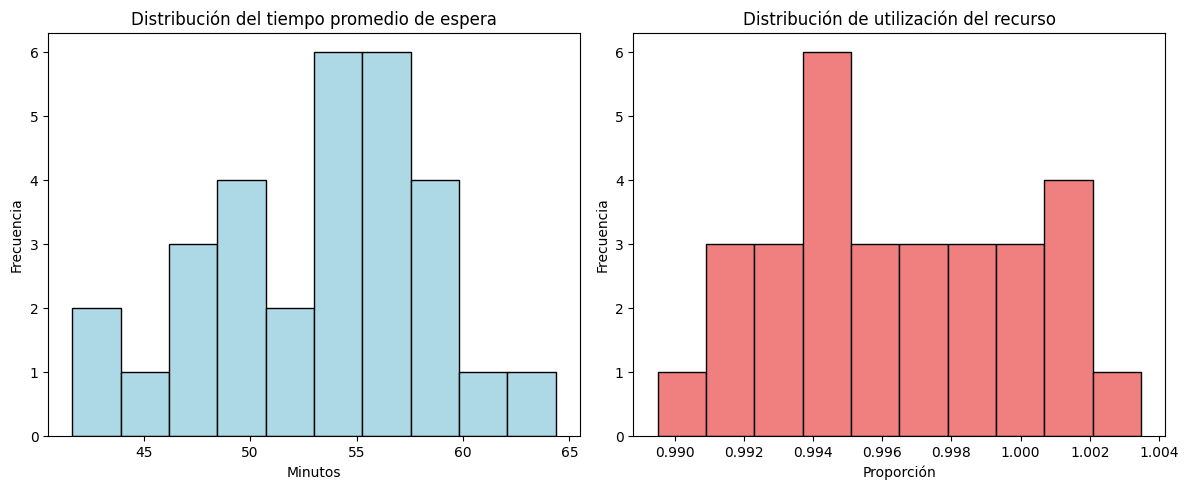

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(df["tiempo_espera_promedio"], bins=10, color='lightblue', edgecolor='black')
axs[0].set_title("Distribución del tiempo promedio de espera")
axs[0].set_xlabel("Minutos")
axs[0].set_ylabel("Frecuencia")

axs[1].hist(df["utilizacion_recurso"], bins=10, color='lightcoral', edgecolor='black')
axs[1].set_title("Distribución de utilización del recurso")
axs[1].set_xlabel("Proporción")
axs[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


## ✅ Conclusiones

- El sistema opera con alta utilización del recurso, lo cual puede provocar acumulación de clientes y tiempos de espera largos.
- La simulación evidencia la necesidad de evaluar mejoras operativas, como incorporar más ventanillas o reducir los tiempos de servicio.
- Experimentar con los parámetros ayuda a entender cómo pequeñas variaciones afectan el desempeño del sistema.

Este ejemplo permite al estudiante apropiarse del ciclo de eventos y de la lógica de simulación de colas de atención.
